In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
# sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/spaghetti/src
/home/akarsh_sakana_ai/.conda/envs/spaghetti/bin/python


In [2]:
import os, sys, glob, pickle, copy, time
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einop import einop

import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [3]:
from clip import CLIP
from cppn import CPPN, FlattenCPPNParameters
import util 

In [4]:
clip = CLIP()

In [5]:
cppn = CPPN(8, 256, nonlin='relu', residual=True, layernorm=True)
cppn = FlattenCPPNParameters(cppn)

ParameterReshaper: 466435 parameters detected for optimization.


In [82]:
class ImageDOFs(nn.Module):
    @nn.compact
    def __call__(self, x):
        img = self.param('img', nn.initializers.zeros_init(), (224, 224, 3))
        rgb = jax.nn.sigmoid(img)
        return rgb, []

    def generate_image(self, params, img_size=224, intermediate_features=False):
        rgb, features = self.apply(params, None)
        if intermediate_features:
            return rgb, features
        else:
            return rgb

In [83]:
cppn = ImageDOFs()
cppn = FlattenCPPNParameters(cppn)

ParameterReshaper: 150528 parameters detected for optimization.


In [84]:
rng = jax.random.PRNGKey(1)
params_sgd = cppn.init(rng, jnp.zeros(3))

In [85]:
txt = "a photo of a very cute cat"
z_txt = clip.embed_txt([txt])[0]
print(z_txt.shape)

(512,)


In [88]:
from imax import transforms, randaugment
def augment_img_impl(rng, img):
    rng, _rng = split(rng)
    sx, sy = jax.random.uniform(_rng, (2, ), minval=0.5, maxval=1.5)
    scale = transforms.scale(sx, sy)

    rng, _rng = split(rng)
    angle = jax.random.uniform(_rng, minval=-90/180*np.pi, maxval=90/180*np.pi)
    rotate = transforms.rotate(angle)

    rng, _rng = split(rng)
    sx, sy = jax.random.uniform(_rng, (2, ), minval=-0.5, maxval=0.5)
    shear = transforms.shear(sx, sy)

    transform = scale @ rotate @ shear
    img = transforms.apply_transform(img, transform, mask_value=0.)
    return img

# Wrapped version with safe gradients
def augment_img_safe(x):
    def f(x):
        return augment_img_impl(*x)
    
    def f_fwd(x):
        return f(x), x
    
    def f_bwd(residual, g):
        return (jnp.where(jnp.isnan(g), 0., g),)
    
    safe_f = jax.custom_vjp(f)
    safe_f.defvjp(f_fwd, f_bwd)
    
    return safe_f(x)
def augment_img(rng, img):
    return augment_img_safe((rng, img))

In [89]:
def loss_fn(params, z_txt, rng):
    img = cppn.generate_image(params, img_size=224)
    img = jax.vmap(augment_img, in_axes=(0, None))(split(rng, 8), img)
    # img = augment_img((rng, img))
    z_img = jax.vmap(clip.embed_img)(img)
    return - (z_img @ z_txt).mean()

@jax.jit
def train_step(state, z_txt, rng):
    loss, grad = jax.value_and_grad(loss_fn)(state.params, z_txt, rng)
    state = state.apply_gradients(grads=grad)
    return state, loss

tx = optax.adam(learning_rate=1e-4)
state = TrainState.create(apply_fn=None, params=params_sgd, tx=tx)

losses = []
pbar = tqdm(range(10000))
for t in pbar:
    rng = jax.random.PRNGKey(t)
    state, loss = train_step(state, z_txt, rng)
    # state, loss = jax.lax.scan(train_step, state, None, length=1000)
    losses.append(loss)
    if t % 100 == 0:
        pbar.set_postfix(loss=loss.item())
losses = np.array(jnp.stack(losses))

params_sgd = state.params

  0%|          | 0/10000 [00:00<?, ?it/s]

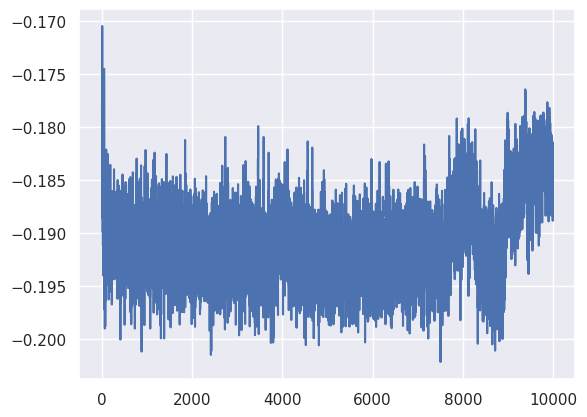

In [234]:
plt.plot(losses)

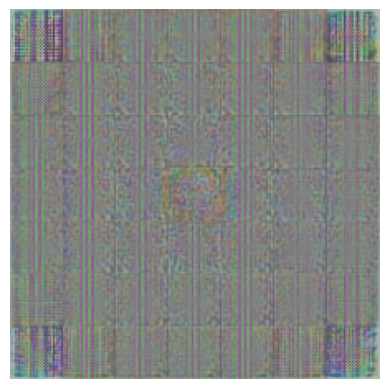

In [90]:
plt.imshow(cppn.generate_image(params_sgd, img_size=224))
plt.grid(False); plt.axis('off')
plt.show()

In [193]:
img = cppn.generate_image(params_sgd, img_size=224)
z_img = clip.embed_img(img)
print(z_img @ z_txt)

0.35570076


0.2507963


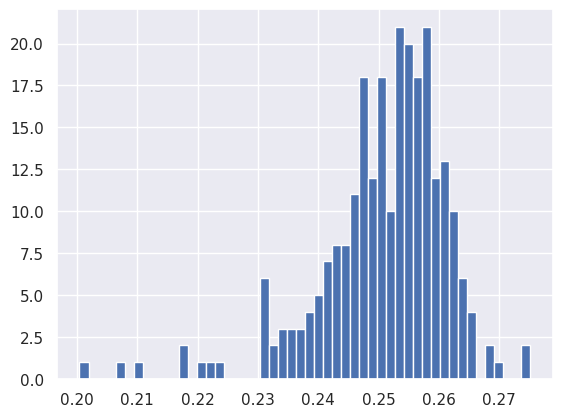

In [203]:
def augment_img(rng, img):
    rng, _rng = split(rng)
    sx, sy = jax.random.uniform(_rng, (2, ), minval=0.5, maxval=1.5)
    scale = transforms.scale(sx, sy)

    rng, _rng = split(rng)
    angle = jax.random.uniform(_rng, minval=-90/180*np.pi, maxval=90/180*np.pi)
    rotate = transforms.rotate(angle)

    rng, _rng = split(rng)
    sx, sy = jax.random.uniform(_rng, (2, ), minval=-0.5, maxval=0.5)
    shear = transforms.shear(sx, sy)

    transform = scale @ rotate @ shear
    img = transforms.apply_transform(img, transform, mask_value=0.)
    return img

img = cppn.generate_image(params_sgd, img_size=224)
img = jax.vmap(augment_img, in_axes=(0, None))(split(rng, 256), img)
z_img = jax.vmap(clip.embed_img)(img)
print((z_img @ z_txt).mean())
plt.hist(np.array(z_img@z_txt), bins=50);

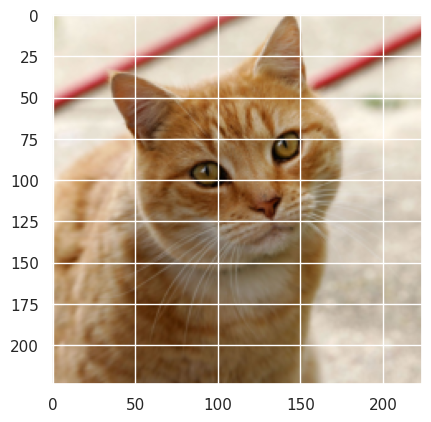

In [116]:
img = plt.imread("../cat.jpg")/255.
img = jax.image.resize(img, (224, 224, 3), method='bilinear')
plt.imshow(img)

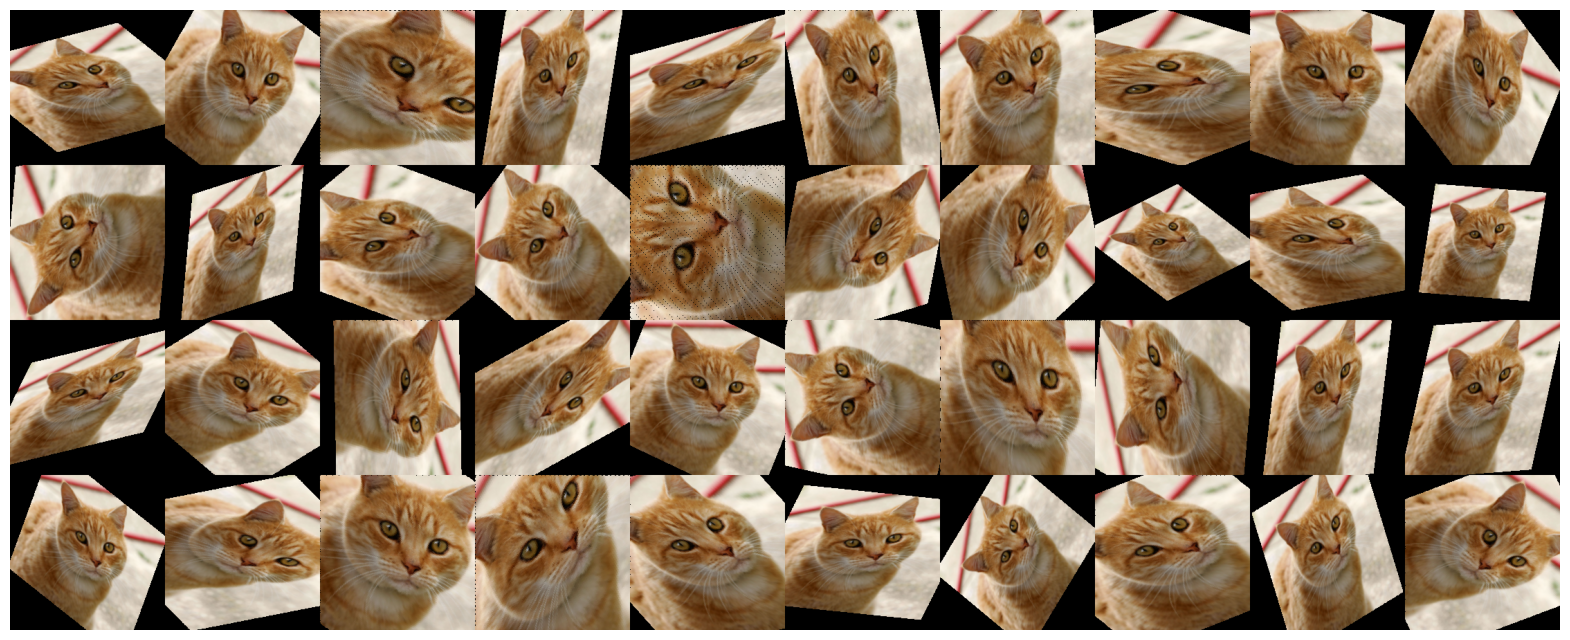

In [117]:


imgp = jax.vmap(augment_img, in_axes=(0, None))(split(rng, 40), img)

plt.figure(figsize=(20, 10))
plt.imshow(rearrange(imgp, "(R C) H W D -> (R H) (C W) D", R=4))
plt.grid(False); plt.axis('off')
plt.show()